# Code zu Lanczos-Verfahren mithilfe von QR-Verfahren

In [2]:
import numpy as np
from scipy.stats import unitary_group
from scipy.linalg import block_diag
from scipy.linalg import qr
import time
import matplotlib.pyplot as plt

### Funktionen zum generiern von Matrizen

In [3]:
def gen_hess(n, compl = False):
    if compl:
        a = np.random.rand(n) + np.random.rand(n)*1j
        b = np.random.rand(n-1) + np.random.rand(n-1)*1j
        c = np.random.rand(n-1) + np.random.rand(n-1)*1j
        return np.diag(b, -1) + np.diag(a,0) + np.diag(c, 1)
    else:
        A = np.zeros((n,n))
        a = np.random.rand(n)*50
        A = A + np.diag(a)
        for j in range(n-1):
            b = np.random.rand(n-j-1)*50
            A = A + np.diag(b,j+1)
        return np.diag(np.random.rand(n-1)*50, -1) + A
    

def gen_upper_tri(eig, compl = False):
    n = eig.shape[0]
    if compl:
        return np.triu(np.random.rand(n,n) + np.random.rand(n,n) * 1j, 1) + np.diag(eig)
    else:
        return np.triu(np.random.rand(n,n),1) + np.diag(eig)
    

def gen_hermite(eig, compl = False):
    n = eig.shape[0]
    B = unitary_group.rvs(n)
    return B.T.conj()@np.diag(eig)@B


def gen_rand_mat(eig, compl = False):
    n = eig.shape[0]
    if compl:
        B = np.random.rand(n,n) + np.random.rand(n,n)*compl*1j
    else:
        B = np.random.rand(n,n)
    return np.linalg.inv(B)@np.diag(eig)@B



#print(gen_hess(5))
#print(gen_upper_tri(np.array([1,2,3]), True))
#print(gen_hermite(np.array([1,2,3,4])))
#print(gen_rand_mat(np.array([1,2,7,4])))



### Verfahren implementiert

In [88]:
def QR_simple(A,tol = 1e-6):
    count = 0
    while abs(A[1,0]) > tol:
        Q,R = np.linalg.qr(A)
        A = R@Q
        count +=1
    return A, sorted(np.diag(A)) ,count



def QR_shift(A,tol=1e-10):
    n = A.shape[1]
    count = 0
    for i in range(n-1,0,-1):
        while abs(A[i,i-1]) > tol:
            rho = A[i,i]
            Q,R = np.linalg.qr(A-rho*np.identity(n))
            A = R@Q + rho*np.identity(n)
            count +=1
        A[i,:i-n] = 0
    return A, sorted(np.diag(A)), count



def QR_shift2(A,tol=1e-12):
    n = A.shape[1]
    count = 0
    for i in range(n-1,0,-1):
        while abs(A[i,i-1]) > tol*(abs(A[i-1,i-1])+abs(A[i,i])):
            w = np.linalg.eigvals(A[i-1:i+1,i-1:i+1])
            if abs(w[0] - A[i,i]) < abs(w[1] - A[i,i]):
                rho = w[0]
            else:
                rho = w[1]
            Q,R = np.linalg.qr(A-rho*np.identity(n))
            A = R@Q + rho*np.identity(n)
            count += 1
        A[i,:i-n] = 0
    return A, sorted(np.diag(A)), count



def QR_hesse(A,tol=1e-12):
    n = A.shape[1]
    count = 0
    for i in range(n-1,0,-1):
        while abs(A[i,i-1]) > tol*(abs(A[i-1,i-1])+abs(A[i,i])):
            w = np.linalg.eigvals(A[i-1:i+1,i-1:i+1])
            if abs(w[0] - A[i,i]) < abs(w[1] - A[i,i]):
                rho = w[0]
            else:
                rho = w[1]
            Q,R = QR_decomp_hesse(A-rho*np.identity(n))
            A = R@Q + rho*np.identity(n)
            count += 1
        A[i,:i-n] = 0
    return A, sorted(np.diag(A)), count



def QR_decomp_hesse(A):
    n = A.shape[0]
    Q = np.eye(n,n)
    
    for i in range(0,n-1):
        if abs(A[i,i]) >= abs(A[i+1,i]):
            t = A[i+1,i]/abs(A[i,i])
            root = (1+abs(t)**2)**(1/2)
            c = A[i,i]/(abs(A[i,i])*root)
            s = t/root
        else:
            t = A[i,i]/abs(A[i+1,i])
            root = (1+abs(t)**2)**(1/2)
            s = A[i+1,i]/(abs(A[i+1,i])*root)
            c = t/root
      
        for j in range(n):
            if j < i:
                temp_2 = Q[i,j]
                Q[i,j] = c.conj()*temp_2 + s.conj()*Q[i+1,j]
                Q[i+1,j] = -s*temp_2 + c*Q[i+1,j]
            else:
                temp_1 = A[i,j]
                A[i,j] = c.conj()*temp_1 + s.conj()*A[i+1,j]
                A[i+1,j] = -s*temp_1 + c*A[i+1,j]
                temp_2 = Q[i,j]
                Q[i,j] = c.conj()*temp_2 + s.conj()*Q[i+1,j]
                Q[i+1,j] = -s*temp_2 + c*Q[i+1,j]
    
    return Q.T.conj(), A

def QR_decomp_hesse_old(A):
    n = A.shape[0]
    Q = np.eye(n,n)

    for i in range(0,n-1):
        if abs(A[i,i]) >= abs(A[i+1,i]):
            t = A[i+1,i]/abs(A[i,i])
            root = (1+abs(t)**2)**(1/2)
            c = A[i,i]/(abs(A[i,i])*root)
            s = t/root
        else:
            t = A[i,i]/abs(A[i+1,i])
            root = (1+abs(t)**2)**(1/2)
            s = A[i+1,i]/(abs(A[i+1,i])*root)
            c = t/root
            
        M = np.array([[c.conj(), s.conj()], [-s, c]])
        G = block_diag(np.eye(i,i), M, np.eye(n-i-2, n-i-2))
        Q = G@Q
        for j in range(i, n):
            temp_1 = A[i,j]
            A[i,j] = c.conj()*temp_1 + s.conj()*A[i+1,j]
            A[i+1,j] = -s*temp_1 + c*A[i+1,j]
    return Q.T.conj(), A

def lanczos(A,k = 0):
    n = A.shape[1]
    if k == 0:
        k = n
        
    v0 = np.random.rand(n)
    v = [v0/np.linalg.norm(v0)]
    gam = [v[0].T.conj()@A@v[0]]
    w = (A - gam[0]*np.identity(n))@v[0]
    delta = [np.linalg.norm(w)]
    i = 0
    while delta[i] > 1e-10 and i < k-1:
        v.append(w/delta[i])
        i +=1
        gam.append(v[i].T.conj()@A@v[i])
        w = (A - gam[i]*np.identity(n))@v[i] - delta[i-1]*v[i-1]
        delta.append(np.linalg.norm(w))
    T = np.diag(delta[:-1], -1) + np.diag(gam) + np.diag(delta[:-1], 1)
    return QR_hesse(T)

def arnoldi(A, dim, k = 0):
    n = dim
    if k == 0:
        k = n
        
    v0 = np.random.rand(n)
    v = [v0/np.linalg.norm(v0)]
    h = np.zeros((k,k))
    
    for j in range(k):
        w = A(v[j])
        for l in range(j+1):
            h[l][j] = w.T.conj()@v[l]
            w = w - h[l][j]*v[l]
        if j < k-1:
            h[j+1][j] = np.sqrt(w.T.conj()@w)
            if abs(h[j+1][j]) < 1e-2:
                return QR_hesse(h[:j+1,:j+1])
            else:
                #print("j=",j)
                #for s in range(j):
                #    print(v[j].T.conj()@v[s])
                #print("------------------------------------")
                v.append(w/h[j+1][j])
    return QR_hesse(h)

### Testing

In [89]:
def error(eig_1, eig_2):
    eig_1 = np.sort(eig_1)
    eig_2 = np.sort(eig_2)
    return np.linalg.norm(eig_1 - eig_2)


def runtime(f,A):
    start = time.time()
    f(A)
    end = time.time()
    return end - start

def runtime_error(f,A):
    start = time.time()
    S = f(A)
    end = time.time()
    return end - start, S

def runtime_error_lanczos(f,A,k):
    start = time.time()
    S = f(A,k)
    end = time.time()
    return end - start, S

def testing(f, n_1, n_2):
    n_array = np.array([i for i in range(n_1,n_2)])
    time_array = []
    error_array = []
    for n in n_array:
        eigv = np.sort(50*np.random.rand(n)-25)
        A = gen_hermite(eigv)
        t, A = runtime_error(f,A)
        err = error(A[1], eigv)
        time_array.append(t)
        error_array.append(err)
    plt.plot(n_array, time_array, label = "runtime")
    #plt.plot(n_array, error_array, 'x', label = "errors")
    plt.legend()
    plt.show()

    
def testing_lanczos(f,k, n_1, n_2):
    n_array = np.array([i for i in range(n_1,n_2)])
    time_array = []
    error_array = []
    for n in n_array:
        eigv = np.sort(50*np.random.rand(n)-25)
        A = gen_hermite(eigv)
        t, A = runtime_error_lanczos(f,A,k)
        err = error(A[1][0], eigv[0])
        time_array.append(t)
        error_array.append(err)
    plt.plot(n_array, time_array, label = "runtime lanczos")
    #plt.plot(n_array, error_array, 'x', label = "errors")
    plt.legend()
    plt.show()
    
def selective_error(eig_1, eig_2, k = 1):
    n_1 = len(eig_1)
    n_2 = len(eig_2)
    error_1 = np.linalg.norm(eig_1[:k] - eig_2[:k])
    error_2 = np.linalg.norm(eig_1[:n_1-k-1:-1] - eig_2[:n_2-k-1:-1])
    return error_1 + error_2

# ------- testing starts here -------

n = 1000

eigv = np.sort(2000*np.random.rand(n)-100)

for k in range(int(n*0.01)):
    eigv[k] = 1.2*eigv[k]-100
    eigv[n-k-1] = 1.2*eigv[n-k-1]+100
#eigv = np.array([-(i+1)*10000 for i in range(n)])
A = gen_hermite(eigv)

def matmul(v):
    return A@v


print(np.sort(eigv))
#print(np.round(QR_simple(A)[1],3))
#print(np.round(QR_shift(A)[1],3))
#print(np.round(QR_shift2(A)[1],3))
#print(np.round(QR_hesse(A)[0],3))
#print(np.round(lanczos(A,30)[1],3))
#print(np.linalg.eigvals(A))
#print(np.sort(np.round(arnoldi(matmul,n)[1], 3)))

#print(error(QR_simple(A)[1], eigv))
#print(error(QR_shift(A)[1], eigv))
#print(error(QR_shift2(A)[1], eigv))
#print(error(lanczos(A)[1], eigv))

#print(error(arnoldi(lambda x: A@x,n, 50)[1],eigv))
#print(arnoldi(lambda x: A@x,n, 50)[1])
#print(runtime(QR_simple, A))
#print(runtime(QR_shift, A))
#print(runtime(QR_shift2, A))
#print(runtime_error_lanczos(lanczos, A, 10)[0])


[-2.19803036e+02 -2.13886796e+02 -2.12412469e+02 -2.11594224e+02
 -2.05566457e+02 -2.04709398e+02 -2.00159021e+02 -1.99778176e+02
 -1.98815140e+02 -1.98092119e+02 -7.99746717e+01 -7.83164283e+01
 -7.82360034e+01 -7.58870172e+01 -7.40042631e+01 -7.33302237e+01
 -7.08737184e+01 -6.84479050e+01 -6.77665795e+01 -6.76339747e+01
 -6.43605410e+01 -6.40430798e+01 -6.29577439e+01 -6.17881035e+01
 -6.16921576e+01 -5.95601512e+01 -5.90510801e+01 -5.66376951e+01
 -5.55946555e+01 -5.54510664e+01 -5.47098978e+01 -5.31637509e+01
 -4.78313969e+01 -4.55237944e+01 -4.29587286e+01 -4.17882428e+01
 -3.99465688e+01 -3.60387612e+01 -3.54056155e+01 -3.42444781e+01
 -3.41270606e+01 -3.08015784e+01 -3.06080834e+01 -2.71307516e+01
 -2.65261614e+01 -2.18398123e+01 -2.06778833e+01 -1.74211794e+01
 -1.31218825e+01 -1.28757535e+01 -1.24142729e+01 -7.98289765e+00
 -7.08745330e+00 -2.93598283e+00 -6.33835423e-02  1.10226906e+00
  2.09075718e+00  7.45187483e+00  7.62514456e+00  7.97960379e+00
  1.05929598e+01  1.06606

In [90]:
k = 120
for k in range(10,40):
    lanczos_test =np.array(lanczos(A,k)[1])
    print(np.sort(lanczos_test))
    error = selective_error(lanczos_test, eigv, 2)


    print("lanczos = ", error)

    #arnoldi_test = arnoldi(lambda x: A@x,n,k)[1]
    #print(np.sort(arnoldi_test))
    #error_1 = selective_error(arnoldi_test, eigv, 2)

    #print("arnoldi=", error_1)

C:\Users\Salli\Anaconda3\lib\site-packages\ipykernel_launcher.py:87: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\Salli\Anaconda3\lib\site-packages\ipykernel_launcher.py:88: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\Salli\Anaconda3\lib\site-packages\ipykernel_launcher.py:80: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\Salli\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: ComplexWarning: Casting complex values to real discards the imaginary part


[-198.35033767-3.02238497e-14j  -18.50857649-3.02238497e-14j
  224.53793667-3.02238497e-14j  490.51648503-3.02238497e-14j
  823.83879616-3.02238497e-14j 1177.24873067-3.02238497e-14j
 1515.48540011-3.02238497e-14j 1786.63212064-1.06214176e-04j
 1970.23623498-3.02238497e-14j 2370.29171262-3.02223131e-14j]
lanczos =  602.9356095210196
[-207.32819773+5.77777258e-15j  -37.28352636+5.77777258e-15j
  159.96608862+5.77777258e-15j  394.04901493-2.88133987e-03j
  690.02289939+5.77777258e-15j 1015.76485247+5.77777258e-15j
 1352.85389671+5.77777258e-15j 1618.8999536 +5.77777258e-15j
 1824.55694676+5.77777258e-15j 2276.83993513+5.77777258e-15j
 2370.33953698+5.77717968e-15j]
lanczos =  277.04042812217494
[-207.58353641-1.73418458e-15j  -50.84560817-1.73418458e-15j
  102.75905355-1.73418458e-15j  321.49047226-1.73418458e-15j
  573.34524274-6.29948124e-02j  855.5212074 -1.73418458e-15j
 1142.33711422-1.73418458e-15j 1443.23216244-1.73418458e-15j
 1677.81326284-1.73418458e-15j 1839.45162987-1.7341845

[-217.68779441-1.02605040e-14j -200.60974495-1.02605040e-14j
 -103.30615582-1.02605040e-14j  -60.7346031 -1.02605040e-14j
    3.67453381-1.02605040e-14j  100.10599205-1.02605040e-14j
  200.34276506-1.02605040e-14j  311.78553017+9.13747333e-02j
  426.42876846-1.02605040e-14j  569.00118079-1.02605040e-14j
  695.19976109-1.02605040e-14j  840.30958888-1.02605040e-14j
  986.0481974 -1.02605040e-14j 1126.63117097-1.02605040e-14j
 1285.86153202-1.02605040e-14j 1419.57825304-1.02605040e-14j
 1535.06202738-1.02605040e-14j 1647.8894495 -1.02605040e-14j
 1747.10582683-1.02605040e-14j 1825.17675563-1.02605040e-14j
 1864.62519092-1.02605040e-14j 2342.99499872-1.02605040e-14j
 2359.04504085-1.02605040e-14j 2369.42949061-1.02605040e-14j
 2377.59005823-1.02751066e-14j]
lanczos =  20.57120839897855
[-217.13349887-1.56471069e-15j -200.62879122-1.56471069e-15j
 -157.53949157-1.56471069e-15j  -64.50097476-1.56471069e-15j
   -7.4807967 -1.56471069e-15j   74.26554678-1.56471069e-15j
  163.86014614-1.5647106

[-218.34487137+2.18302378e-14j -210.14019463+2.18302378e-14j
 -199.69043573+2.18302378e-14j  -84.75042099+2.18302378e-14j
  -64.50818924+2.18302378e-14j  -24.61238576+2.18302378e-14j
   24.50296975+2.18302378e-14j   98.20874454+2.18302378e-14j
  163.7146487 +2.18302378e-14j  254.63737016+2.10721255e-05j
  336.60337018+2.18302378e-14j  420.05368678+2.18302378e-14j
  513.80891213+2.18302378e-14j  621.32560786+2.18302378e-14j
  710.41560142+2.18302378e-14j  817.36593067+2.18302378e-14j
  933.66981757+2.18302378e-14j 1034.07050009+2.18302378e-14j
 1132.50913317+2.18302378e-14j 1248.59319748+2.18302378e-14j
 1344.16575117+2.18302378e-14j 1443.65591716+2.18302378e-14j
 1522.30960758+2.18302378e-14j 1612.50409338+2.18302378e-14j
 1698.88245952+2.18302378e-14j 1752.44401681+2.18302378e-14j
 1802.03943045+2.18302378e-14j 1853.00517166+2.18302378e-14j
 1874.11814053+2.18302378e-14j 2357.13266043+2.18199731e-14j
 2361.0417233 +2.18302378e-14j 2371.031584  +2.18302378e-14j
 2375.22062037+2.1830237

In [ ]:
 for k in range(20, 100):
    print(np.array(lanczos(A,k)[1]))
    print("----------------")

In [95]:
k = [i*10 for i in range(1,60)]

n = len(k)
mat_array = [0]*n
mat_array_2 = [0]*n
for j in range(n):
    mat_array[j] = (gen_hess(k[j]))
    mat_array_2[j] = gen_rand_mat(np.random.rand(k[j])*500)
time_good = [0]*n
time_bad = [0]*n


In [96]:
for j in range(len(k)):
    time_good[j] = runtime(QR_decomp_hesse, mat_array[j])
    time_bad[j] = runtime(np.linalg.qr, mat_array_2[j])

<IPython.core.display.Javascript object>


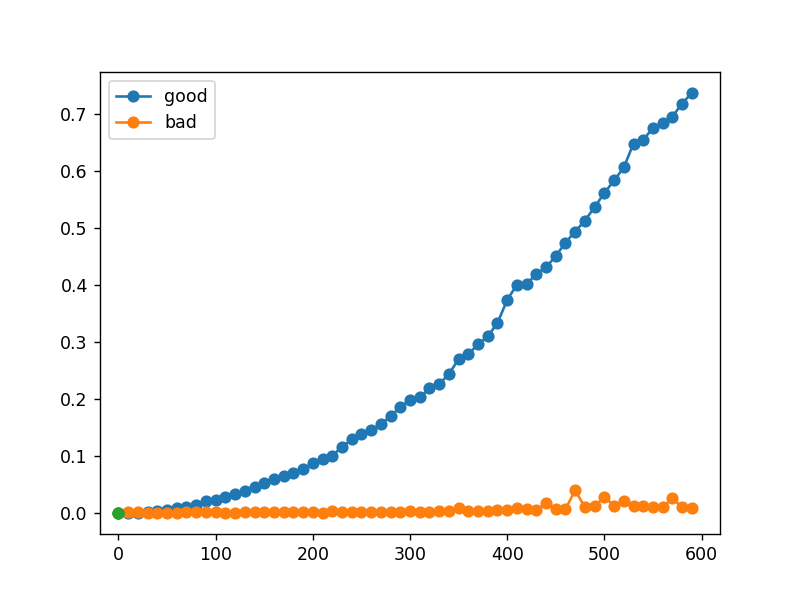

In [97]:
%matplotlib notebook

plt.plot(k, time_good, '-o', label = "good")
plt.plot(k, time_bad, '-o',label = "bad")

plt.legend()
plt.show()

In [146]:
n_dim = 500 

eigvalues = np.sort(2*np.random.rand(n_dim))
eigvalues[-1] = 3
eigvalues[-2] = 2.5
eigvalues[0] = -1
eigvalues[1] = -0.5
L = gen_hermite(eigvalues)

j = 10

In [147]:
lanczos_arr = [[0]]*j

for l in range(j):
    lanczos_arr[l] = lanczos(L,l+2)[1]

C:\Users\Salli\Anaconda3\lib\site-packages\ipykernel_launcher.py:87: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\Salli\Anaconda3\lib\site-packages\ipykernel_launcher.py:88: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\Salli\Anaconda3\lib\site-packages\ipykernel_launcher.py:80: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\Salli\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: ComplexWarning: Casting complex values to real discards the imaginary part


500


<IPython.core.display.Javascript object>


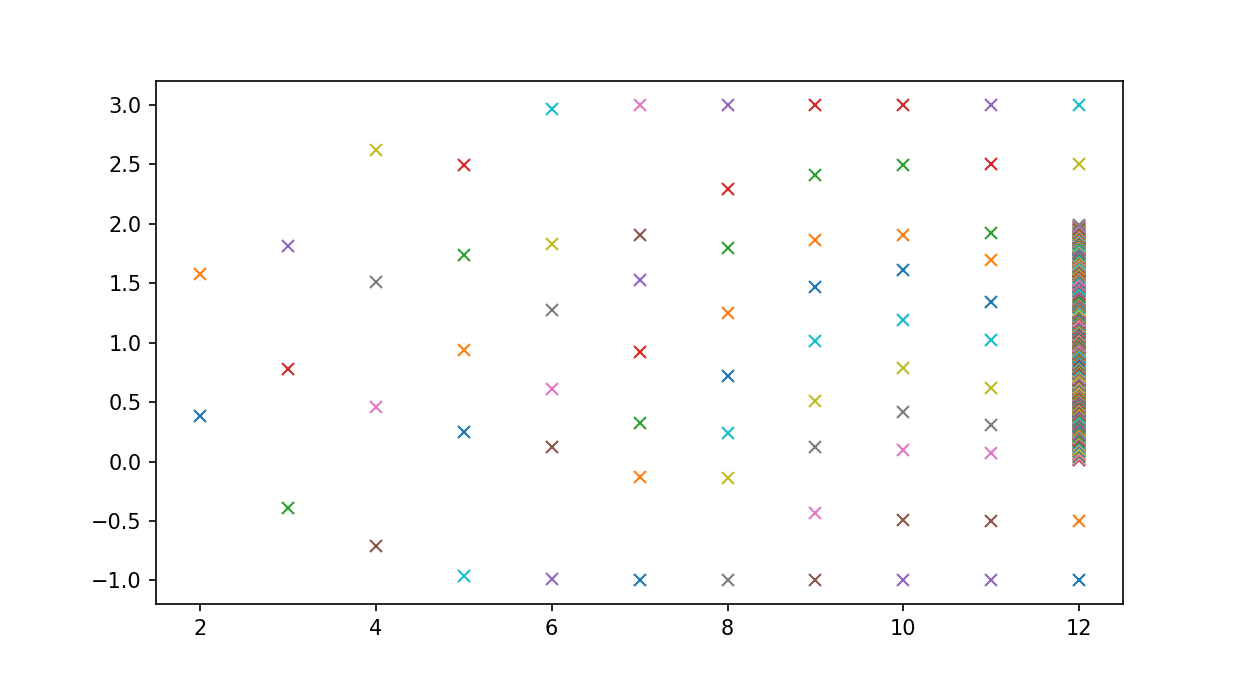

In [148]:
%matplotlib notebook
print(n_dim)
for l in range(n_dim):
    plt.plot(12,eigvalues[l], 'x')
for l in range(len(lanczos_arr)):
    for k in range(len(lanczos_arr[l])):
        plt.plot(l+2, lanczos_arr[l][k], 'x')
plt.show()